In [399]:
# @title Experiment Config { display-mode: "form" }
# @markdown Set hyperparameters and scaler choice

use_sentiment = True  # @param {type:"boolean"}
save = True  # @param {type:"boolean"}
window_size = 20  # @param {type:"integer"}
scaler_choice = "RobustScaler"  # @param ["MinMaxScaler", "StandardScaler", "RobustScaler"]
loss_fn = "mse"  # @param ["mse", "mae", "mape", "huber"]
epochs = 200  # @param {type:"integer"}
batch_size = 32  # @param {type:"integer"}
model_name = "bilstm_attention" # @param ["default", "stacked_lstm", "gru", "lstm_gru", "transformer", "cnn_lstm", "bi_lstm", "bilstm_attention", "lstm_attention"]

# LSTM-Based Multivariate Time Series Forecasting

Predicting stock prices using past prices and average daily sentiment

In [400]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.metrics import (
    mean_absolute_error,
    mean_absolute_percentage_error,
    mean_squared_error,
    median_absolute_error,
    r2_score,
    max_error,
    explained_variance_score,
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

from tensorflow.keras import Input
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    LSTM,
    GRU,
    Dense,
    Dropout,
    Add,
    Flatten,
    LayerNormalization,
    Attention,
    GlobalAveragePooling1D,
    AdditiveAttention,
    Permute,
    Reshape,
    Multiply,
    MultiHeadAttention,
    Conv1D,
    MaxPooling1D,
    Bidirectional
)

# Ensure reproducibility
SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
os.environ["TF_DETERMINISTIC_OPS"] = "1"
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

plt.style.use("seaborn-v0_8-darkgrid")

In [401]:
evals_path = "evals.csv"
preds_path = "preds.csv"
if save:
    all_evals = pd.read_csv(evals_path).to_dict(orient="records")
    all_preds = [pd.read_csv(preds_path)]

### Load and Scale Data
We normalize both price and sentiment for LSTM input. The target variable is next-day price.

In [402]:
df = pd.read_csv("https://raw.githubusercontent.com/sidmaji/financial-sentiment-analysis/refs/heads/main/data/processed/prices_and_sentiments.csv", parse_dates=["date"])
df.set_index("date", inplace=True)
df.head()

,avg_sentiment,price
date,,
2024-07-30,0.000,103.697243
2024-07-31,0.250,116.983040
2024-08-01,0.000,109.175514
2024-08-02,-0.375,107.236115
2024-08-03,0.000,107.236115


In [403]:
if use_sentiment:
    features = ["price", "avg_sentiment"]
else:
    features = ["price"]
target = "price"

scaler_map = {
    "MinMaxScaler": MinMaxScaler(),
    "StandardScaler": StandardScaler(),
    "RobustScaler": RobustScaler(),
}
scaler = scaler_map[scaler_choice]

scaled = scaler.fit_transform(df[features])
scaled_df = pd.DataFrame(scaled, columns=features, index=df.index)
scaled_df.head()

,price,avg_sentiment
date,,
2024-07-30,-1.256634,-0.333333
2024-07-31,-0.683373,0.333333
2024-08-01,-1.020255,-0.333333
2024-08-02,-1.103937,-1.333333
2024-08-03,-1.103937,-0.333333


## Sequence Generation
We create overlapping windows of multivariate time series data to feed into the LSTM.

In [404]:
def create_sequences(data, target_index=0, window_size=5):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size][target_index])
    return np.array(X), np.array(y)

data = scaled_df.values
X, y = create_sequences(data, target_index=0, window_size=window_size)

print(f"X shape: {X.shape} | y shape: {y.shape}")

X shape: (337, 20, 2) | y shape: (337,)


In [405]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [406]:
def build_model(model_type="default", input_shape=(window_size, X.shape[2])):
    if model_type == "default":
        return Sequential([
            Input(shape=input_shape),
            LSTM(32, dropout=0.1, recurrent_dropout=0.1),
            Dense(32, activation="relu"),
            Dropout(0.2),
            Dense(1)
        ])
    if model_type == "stacked_lstm":
        return Sequential([
            Input(shape=input_shape),
            LSTM(64, return_sequences=True, dropout=0.1, recurrent_dropout=0.1),
            LSTM(32, dropout=0.1, recurrent_dropout=0.1),
            Dense(32, activation="relu"),
            Dropout(0.2),
            Dense(1)
        ])
    if model_type == "gru":
        return Sequential([
            Input(shape=input_shape),
            GRU(64, return_sequences=True, dropout=0.1, recurrent_dropout=0.1),
            GRU(32, dropout=0.1, recurrent_dropout=0.1),
            Dense(32, activation="relu"),
            Dropout(0.2),
            Dense(1)
        ])
    if model_type == "lstm_gru":
        return Sequential([
            Input(shape=input_shape),
            LSTM(64, return_sequences=True, dropout=0.1, recurrent_dropout=0.1),
            GRU(64, dropout=0.1, recurrent_dropout=0.1),
            LayerNormalization(),
            Dropout(0.2),
            Dense(64, activation="relu"),
            Dropout(0.2),
            Dense(32, activation="relu"),
            Dense(1)
        ])
    if model_type == "transformer":
        inputs = Input(shape=input_shape)
        x = LayerNormalization()(inputs)
        attn_out = MultiHeadAttention(num_heads=4, key_dim=32)(x, x)
        x = Add()([attn_out, x])
        x = LayerNormalization()(x)
        # Feed-forward block
        x_ff = Dense(128, activation="relu")(x)
        x_ff = Dense(input_shape[1])(x_ff)
        x = Add()([x, x_ff])
        x = GlobalAveragePooling1D()(x)
        x = Dense(64, activation="relu")(x)
        x = Dropout(0.1)(x)
        output = Dense(1)(x)
        return Model(inputs, output)
    if model_type == "cnn_lstm":
        model = Sequential([
            Input(shape=input_shape),
            Conv1D(64, kernel_size=3, activation="relu"),
            MaxPooling1D(pool_size=2),
            LSTM(64),
            Dense(32, activation="relu"),
            Dropout(0.2),
            Dense(1)
        ])
        return model
    if model_type == "bi_lstm":
        return Sequential([
            Input(shape=input_shape),
            Bidirectional(LSTM(64, return_sequences=True, dropout=0.1)),
            Bidirectional(LSTM(32, dropout=0.1)),
            Dense(32, activation="relu"),
            Dropout(0.2),
            Dense(1)
        ])
    if model_type == "bilstm_attention":
        inputs = Input(shape=input_shape)
        x = Bidirectional(LSTM(64, return_sequences=True))(inputs)
        x = Bidirectional(LSTM(64, return_sequences=True))(x)
        attn = AdditiveAttention()([x, x])
        x = Add()([x, attn])
        x = GlobalAveragePooling1D()(x)
        x = LayerNormalization()(x)
        x = Dropout(0.2)(x)
        x = Dense(64, activation="relu")(x)
        x = Dropout(0.2)(x)
        x = Dense(32, activation="relu")(x)
        output = Dense(1)(x)
        return Model(inputs, output)
    if model_type == "lstm_attention":
        inputs = Input(shape=input_shape)
        x = LSTM(64, return_sequences=True)(inputs)
        x = LSTM(64, return_sequences=True)(x)
        attn = AdditiveAttention()([x, x])
        x = Multiply()([x, attn])
        x = GlobalAveragePooling1D()(x)
        x = LayerNormalization()(x)
        x = Dropout(0.2)(x)
        output = Dense(1)(x)
        return Model(inputs, output)

In [407]:
model = build_model(model_name)

model.compile(optimizer="adam", loss=loss_fn)
model.summary()

Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_19      │ (None, 20, 2)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_6     │ (None, 20, 128)   │     34,304 │ input_layer_19[0… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_7     │ (None, 20, 128)   │     98,816 │ bidirectional_6[… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ additive_attention… │ (None, 20, 128)   │        128 │ bidirectional_7[… │
│ (AdditiveAttention) │                   │            │ bidirectional_7[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_5 (Add)         │ (None, 20, 128)   │          0 │ bidirectional_7[… │
│                     │                   │            │ additive_attenti… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ add_5[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 128)       │        256 │ global_average_p… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_22          │ (None, 128)       │          0 │ layer_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_39 (Dense)    │ (None, 64)        │      8,256 │ dropout_22[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_23          │ (None, 64)        │          0 │ dense_39[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_40 (Dense)    │ (None, 32)        │      2,080 │ dropout_23[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_41 (Dense)    │ (None, 1)         │         33 │ dense_40[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 143,873 (562.00 KB)

 Trainable params: 143,873 (562.00 KB)

 Non-trainable params: 0 (0.00 B)

In [408]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=30, restore_best_weights=True)]
)

Epoch 1/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 12s 189ms/step - loss: 0.3522 - val_loss: 0.6382
Epoch 2/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - loss: 0.2235 - val_loss: 0.2275
Epoch 3/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - loss: 0.1598 - val_loss: 0.4152
Epoch 4/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - loss: 0.1387 - val_loss: 0.2386
Epoch 5/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 0.1290 - val_loss: 0.3468
Epoch 6/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.1169 - val_loss: 0.2520
Epoch 7/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.1028 - val_loss: 0.3055
Epoch 8/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.1102 - val_loss: 0.2414
Epoch 9/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.1102 - val_loss: 0.2652
Epoch 10/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.1005 - val_loss: 0.2172
Epoch 11/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.0993 - val_loss: 0.2553
Epoch 12/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.0955 - va

In [409]:
# Predict
y_pred = model.predict(X_test)

# Pad y values with dummy columns to match scaler's expected shape
# This assumes that the target variable is always the first column (price)
pad_width = len(features) - 1
y_test_pad = np.column_stack([y_test] + [np.zeros_like(y_test) for _ in range(pad_width)])
y_pred_pad = np.column_stack([y_pred.ravel()] + [np.zeros_like(y_test) for _ in range(pad_width)])

# Inverse transform
y_test_inv = scaler.inverse_transform(y_test_pad)[:, 0]
y_pred_inv = scaler.inverse_transform(y_pred_pad)[:, 0]

# For full price plot
price_full_inv = scaler.inverse_transform(scaled_df[features])[:, 0]

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 344ms/step


In [410]:
run_id = f"{'baseline_' if not use_sentiment else ''}ws{window_size}_scaler{scaler_choice}_loss{loss_fn}_bs{batch_size}_ep{epochs}"
if model_name != "default":
  run_id += f"_{model_name}"
# Add to prediction log
pred_df = pd.DataFrame({
    "date": df.index[-len(y_test):],
    "actual": y_test_inv,
    "predicted": y_pred_inv,
    "run_id": run_id,
    "window_size": window_size,
    "scaler": scaler_choice,
    "loss_fn": loss_fn,
    "epochs": epochs,
    "batch_size": batch_size,
})

all_preds.append(pred_df)

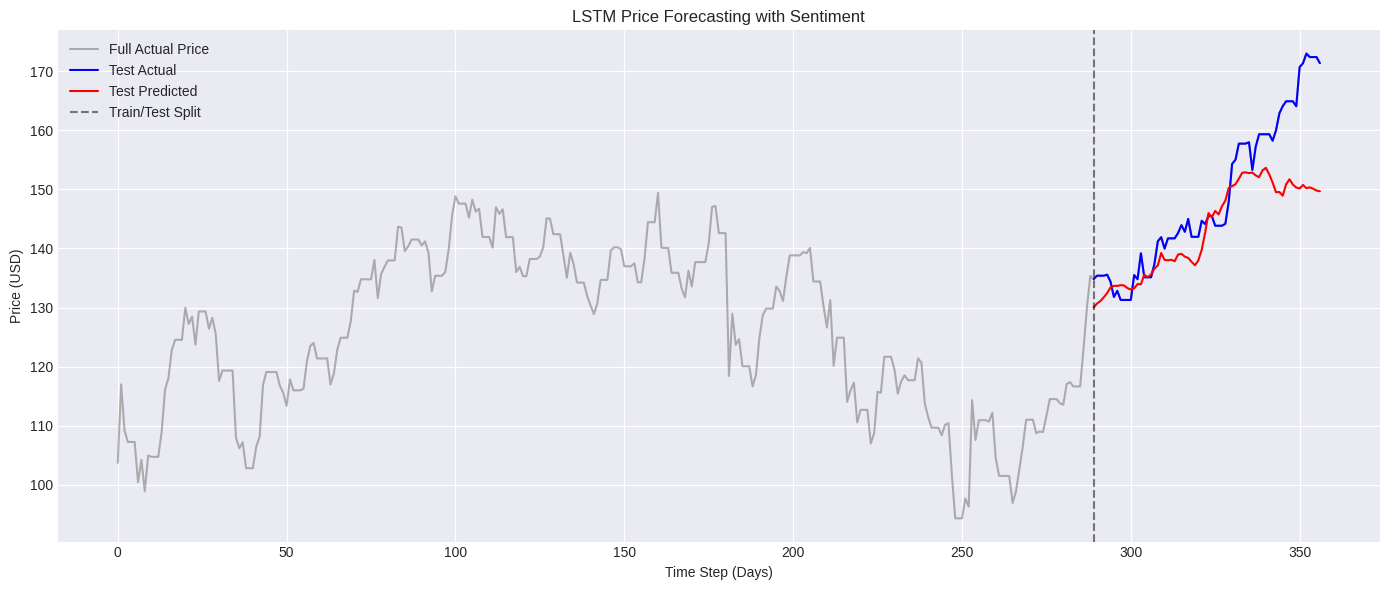

In [411]:
plt.figure(figsize=(14, 6))
plt.plot(price_full_inv, label="Full Actual Price", color="gray", alpha=0.6)

split = len(price_full_inv) - len(y_test)
plt.plot(range(split, len(price_full_inv)), y_test_inv, label="Test Actual", color="blue")
plt.plot(range(split, len(price_full_inv)), y_pred_inv, label="Test Predicted", color="red")

plt.axvline(split, linestyle="--", color="black", alpha=0.5, label="Train/Test Split")
plt.title("LSTM Price Forecasting with Sentiment")
plt.xlabel("Time Step (Days)")
plt.ylabel("Price (USD)")
plt.legend()
plt.tight_layout()
plt.show()

In [412]:
def smape_func(y_true, y_pred):
    return 100 * np.mean(
        2.0 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + 1e-8)
    )

# Core metrics
mae = mean_absolute_error(y_test_inv, y_pred_inv)
mape = mean_absolute_percentage_error(y_test_inv, y_pred_inv)
smape = smape_func(y_test_inv, y_pred_inv)
mse = mean_squared_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_inv, y_pred_inv)

# Normalized metrics (to make values more interpretable across different stock price levels)
price_range = y_test_inv.max() - y_test_inv.min()
nmae = mae / price_range
nmse = mse / price_range
nrmse = rmse / price_range

# Other relevant metrics
medae = median_absolute_error(y_test_inv, y_pred_inv)
maxerr = max_error(y_test_inv, y_pred_inv)
evs = explained_variance_score(y_test_inv, y_pred_inv)

# Display all
print(f"MAE (Mean Absolute Error):                   {mae:.4f}")
print(f"MAPE (Mean Absolute % Error):                {mape:.4f}")
print(f"SMAPE (Symmetric Mean Absolute % Error):     {smape:.4f}")
print(f"MSE (Mean Squared Error):                    {mse:.4f}")
print(f"RMSE (Root Mean Squared Error):              {rmse:.4f}")
print(f"R² (R-squared Score):                        {r2:.4f}")
print(f"NMAE (Normalized MAE):                       {nmae:.4f}")
print(f"NRMSE (Normalized RMSE):                     {nrmse:.4f}")
print(f"MedAE (Median Absolute Error):               {medae:.4f}")
print(f"Max Error:                                   {maxerr:.4f}")
print(f"Explained Variance Score:                    {evs:.4f}")

MAE (Mean Absolute Error):                   6.3274
MAPE (Mean Absolute % Error):                0.0400
SMAPE (Symmetric Mean Absolute % Error):     4.1467
MSE (Mean Squared Error):                    79.8951
RMSE (Root Mean Squared Error):              8.9384
R² (R-squared Score):                        0.5120
NMAE (Normalized MAE):                       0.1517
NRMSE (Normalized RMSE):                     0.2143
MedAE (Median Absolute Error):               4.1794
Max Error:                                   22.7858
Explained Variance Score:                    0.6992


In [413]:
eval_metrics = {
    "run_id": run_id,
    "window_size": window_size,
    "scaler": scaler_choice,
    "loss_fn": loss_fn,
    "epochs": epochs,
    "batch_size": batch_size,
    "mae": mae,
    "mape": mape,
    "smape": smape,
    "mse": mse,
    "rmse": rmse,
    "r2": r2,
    "nmae": nmae,
    "nmse": nmse,
    "nrmse": nrmse,
    "medae": medae,
    "max_error": maxerr,
    "explained_var": evs,
}

all_evals.append(eval_metrics)

In [414]:
preds_df = pd.concat(all_preds, ignore_index=True)
evals_df = pd.DataFrame(all_evals)
evals_df.drop(columns="Unnamed: 0", errors="ignore", inplace=True)

if save:
    preds_df.to_csv(preds_path, index=False)
    evals_df.to_csv(evals_path, index=False)

# Checking Evaluations

In [415]:
if save:
    evals_df = pd.read_csv(evals_path)
    preds_df = pd.read_csv(preds_path)
evals_df

,run_id,window_size,scaler,loss_fn,epochs,batch_size,mae,mape,smape,mse,rmse,r2,nmae,nmse,nrmse,medae,max_error,explained_var
0,ws5_scalerMinMaxScaler_lossmse_bs32_ep200,5,MinMaxScaler,mse,200,32,5.405359,0.035195,3.612354,44.267464,6.653380,0.743641,0.108089,0.885198,0.133045,5.024365,13.931433,9.090422e-01
1,ws5_scalerStandardScaler_lossmse_bs32_ep200,5,StandardScaler,mse,200,32,5.713792,0.036389,3.752566,59.482824,7.712511,0.655527,0.114256,1.189453,0.154224,3.112406,18.053008,8.110990e-01
2,ws5_scalerRobustScaler_lossmse_bs32_ep200,5,RobustScaler,mse,200,32,4.135218,0.026652,2.717087,30.319870,5.506348,0.824414,0.082690,0.606294,0.110108,3.456375,15.946779,8.763429e-01
3,ws10_scalerRobustScaler_lossmse_bs32_ep200,10,RobustScaler,mse,200,32,5.574625,0.035605,3.663318,54.969152,7.414118,0.669404,0.129405,1.276007,0.172105,4.064490,16.634149,8.119724e-01
4,ws20_scalerRobustScaler_lossmse_bs32_ep200,20,RobustScaler,mse,200,32,3.709538,0.023685,2.412774,25.152672,5.015244,0.846357,0.088917,0.602905,0.120215,2.925522,12.628627,8.997737e-01
5,ws30_scalerRobustScaler_lossmse_bs32_ep200,30,RobustScaler,mse,200,32,4.145520,0.026206,2.675442,32.234144,5.677512,0.802279,0.099367,0.772647,0.136089,2.629619,14.603917,8.622058e-01
6,ws20_scalerRobustScaler_lossmae_bs32_ep200,20,RobustScaler,mae,200,32,4.949298,0.031417,3.220642,43.843884,6.621471,0.732183,0.118634,1.050930,0.158716,2.920149,15.315729,8.365590e-01
7,ws20_scalerRobustScaler_lossmape_bs32_ep200,20,RobustScaler,mape,200,32,14.347048,0.091024,9.779824,329.537622,18.153171,-1.012958,0.343896,7.898960,0.435128,9.921987,36.320778,2.062982e-01
8,ws20_scalerRobustScaler_losshuber_bs32_ep200,20,RobustScaler,huber,200,32,4.375090,0.027924,2.852782,33.685597,5.803929,0.794234,0.104870,0.807438,0.139119,2.901915,13.555063,8.692729e-01
9,ws20_scalerRobustScaler_lossmse_bs16_ep200,20,RobustScaler,mse,200,16,4.545561,0.028788,2.947658,36.799256,6.066239,0.775214,0.108956,0.882072,0.145407,3.061425,14.530927,8.749502e-01


In [423]:
evals_df.sort_values(by="r2", ascending=False)

,run_id,window_size,scaler,loss_fn,epochs,batch_size,mae,mape,smape,mse,rmse,r2,nmae,nmse,nrmse,medae,max_error,explained_var
26,ws20_scalerRobustScaler_lossmse_bs32_ep200_bi_...,20,RobustScaler,mse,200,32,3.018884,0.019704,1.998322,14.855963,3.854343,0.909253,0.072362,0.356095,0.092388,2.432240,8.559124,9.425239e-01
16,ws20_scalerRobustScaler_lossmse_bs32_ep200_lst...,20,RobustScaler,mse,200,32,3.606547,0.024490,2.461255,21.199419,4.604283,0.870505,0.086448,0.508146,0.110364,2.888598,14.921466,8.711431e-01
14,ws20_scalerRobustScaler_lossmse_bs32_ep200_sta...,20,RobustScaler,mse,200,32,3.517138,0.022861,2.311617,21.816766,4.670842,0.866734,0.084305,0.522944,0.111959,2.853624,12.546828,8.860272e-01
25,baseline_ws20_scalerRobustScaler_lossmse_bs32_...,20,RobustScaler,mse,200,32,3.657025,0.023568,2.399424,22.156554,4.707075,0.864658,0.087658,0.531089,0.112828,2.978996,11.702240,9.321197e-01
4,ws20_scalerRobustScaler_lossmse_bs32_ep200,20,RobustScaler,mse,200,32,3.709538,0.023685,2.412774,25.152672,5.015244,0.846357,0.088917,0.602905,0.120215,2.925522,12.628627,8.997737e-01
2,ws5_scalerRobustScaler_lossmse_bs32_ep200,5,RobustScaler,mse,200,32,4.135218,0.026652,2.717087,30.319870,5.506348,0.824414,0.082690,0.606294,0.110108,3.456375,15.946779,8.763429e-01
23,baseline_ws20_scalerRobustScaler_lossmse_bs32_...,20,RobustScaler,mse,200,32,4.126805,0.026314,2.681609,28.778655,5.364574,0.824208,0.098919,0.689819,0.128588,2.789139,13.591599,8.891393e-01
17,baseline_ws20_scalerRobustScaler_lossmse_bs32_...,20,RobustScaler,mse,200,32,4.304068,0.027690,2.827478,29.582127,5.438945,0.819300,0.103168,0.709078,0.130371,3.279793,12.700623,9.218420e-01
5,ws30_scalerRobustScaler_lossmse_bs32_ep200,30,RobustScaler,mse,200,32,4.145520,0.026206,2.675442,32.234144,5.677512,0.802279,0.099367,0.772647,0.136089,2.629619,14.603917,8.622058e-01
18,ws20_scalerRobustScaler_lossmse_bs32_ep200_gru,20,RobustScaler,mse,200,32,4.288773,0.027290,2.789204,32.636409,5.712828,0.800643,0.102801,0.782289,0.136936,2.978042,13.111237,8.812253e-01


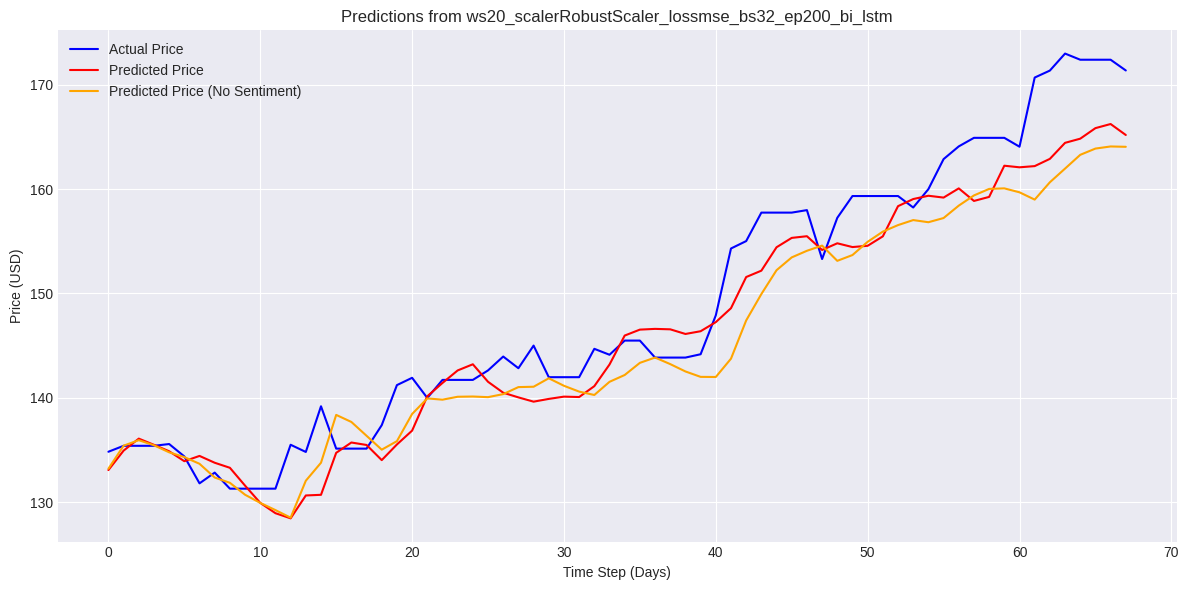

In [419]:
best_run = "ws20_scalerRobustScaler_lossmse_bs32_ep200_bi_lstm"
no_sentiment = "baseline_ws20_scalerRobustScaler_lossmse_bs32_ep200_bi_lstm"

best_preds = preds_df[preds_df["run_id"] == best_run].copy()
no_sentiment_preds = preds_df[preds_df["run_id"] == no_sentiment].copy()

plt.figure(figsize=(12, 6))
plt.plot(best_preds["actual"].values, label="Actual Price", color="blue")
plt.plot(best_preds["predicted"].values, label="Predicted Price", color="red")
plt.plot(no_sentiment_preds["predicted"].values, label="Predicted Price (No Sentiment)", color="orange")
plt.title(f"Predictions from {best_run}")
plt.xlabel("Time Step (Days)")
plt.ylabel("Price (USD)")
plt.legend()
plt.tight_layout()
plt.show()

In [418]:
from google.colab import files
files.download(evals_path)
files.download(preds_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>